In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch
from sklearn.model_selection import train_test_split

class SegmentationDataset(Dataset):
  def __init__(self, images, labels, transforms):
    # store the image and mask filepaths, and augmentation
		# transforms
    self.transforms = transforms
    self.images = images
    self.labels = labels
  def __len__(self):
    # return the number of total samples contained in the dataset
    return np.array(self.images).shape[0]
  def __getitem__(self, idx):
    try:
      image = self.images[idx]
      mask = self.labels[idx]
    except:
      print ("no index at", idx)
    #image = self.images[idx]
		# load the image from disk, swap its channels from BGR to RGB,

		# and read the associated mask from disk in grayscale mode
		# check to see if we are applying any transformations
      if self.transforms is not None:
			# apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.transforms(mask)
		# return a tuple of the image and its mask
    return (image, torch.Tensor(mask).long())

In [ ]:
!pip install -q einops
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision import transforms
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
DATASET_DIRECTORY = "/content/drive/MyDrive/IBM_Spring24/mangrove_dataset/jamaica_mangrove/"
PRETRAINED_MODEL_NAME = "nvidia/mit-b5"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
PERCENT_NOMANGROVE_TILE_KEEP = 0.2
BATCH_SIZE = 32
INIT_LR = 0.0001 #0.0001 #0.00006
LOSS_FUNCTION = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 4.0]))
NUM_EPOCHS = 20
TEST_EVAL_EVERY_BATCH = 5 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 3 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

In [ ]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle

with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

In [ ]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [ ]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)

#systemic undersampling of 0 class
mask_sums = trainMasks.sum(axis=(1, 2))
non_empty_indices = mask_sums > 0

non_empty_indices_ls = non_empty_indices.tolist()
non_empty_indices = []
for element in non_empty_indices_ls:
    if element == False:
        if random.random() < PERCENT_NOMANGROVE_TILE_KEEP:
            non_empty_indices.append(True)
        else:
            non_empty_indices.append(False)
    else:
          non_empty_indices.append(True)

trainImages = trainImages[non_empty_indices]
trainMasks = trainMasks[non_empty_indices]


# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 1477 examples in the training set.
found 410 examples in the test set.


In [ ]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

In [ ]:
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2
)

# Modify the first layer to match the number of channels in data
modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
model.segformer.encoder.patch_embeddings[0].proj = modified_layer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)

In [ ]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized")

Model Initialized


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [ ]:
class Total_updater:
  def __init__(self):
    self.test_epoch = []
    self.test_acc = []
    self.test_avr_acc = []
    self.test_loss = []
    self.test_avr_loss = []
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0
    self.tests_epoch_count = 0

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)

    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")


    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1

In [ ]:
early_stopper = Early_stopper()
total_updater = Total_updater()

In [ ]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()

    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss


        logits_flat = upsampled_logits.reshape(-1, 2)  # Reshape logits to [batch_size * height * width, num_classes]
        labels_one_hot = nn.functional.one_hot(labels.view(-1), num_classes=2)
        loss_fn = LOSS_FUNCTION.cuda()
        bce_loss = loss_fn(logits_flat, labels_one_hot.float())


        total_updater.update_train(accuracy, loss.item())
        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            next_test_batch = next(test_batch)
            test_pixel_values = next_test_batch[0].to(device)
            test_labels = next_test_batch[1].to(device)
            test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
            test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
            test_predicted = test_upsampled_logits.argmax(dim=1)
            test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
            test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
            test_true_labels = test_labels[test_mask].detach().cpu().numpy()
            test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
            test_loss = test_outputs.loss

            total_updater.update_test(test_accuracy, test_loss.item())

            print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
            model.train()


        # backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):
        break

Epoch: 0


  0%|          | 0/47 [00:04<?, ?it/s, Batch=0, Batch Train Accuracy=0.455, Train Loss=0.742]

Batch Test Accuracy: 0.7280006408691406, Test Loss: 0.6780176162719727


 11%|█         | 5/47 [00:11<01:04,  1.53s/it, Batch=5, Batch Train Accuracy=0.736, Train Loss=0.546]

Batch Test Accuracy: 0.7659645080566406, Test Loss: 0.6439711451530457


 21%|██▏       | 10/47 [00:17<00:42,  1.15s/it, Batch=10, Batch Train Accuracy=0.756, Train Loss=0.514]

Batch Test Accuracy: 0.8618183135986328, Test Loss: 0.5609471201896667


 32%|███▏      | 15/47 [00:23<00:35,  1.11s/it, Batch=15, Batch Train Accuracy=0.843, Train Loss=0.387]

Batch Test Accuracy: 0.9469318389892578, Test Loss: 0.44471094012260437


 43%|████▎     | 20/47 [00:28<00:29,  1.08s/it, Batch=20, Batch Train Accuracy=0.765, Train Loss=0.469]

Batch Test Accuracy: 0.7831859588623047, Test Loss: 0.6193482279777527


 53%|█████▎    | 25/47 [00:34<00:24,  1.11s/it, Batch=25, Batch Train Accuracy=0.721, Train Loss=0.494]

Batch Test Accuracy: 0.8140449523925781, Test Loss: 0.4247688055038452


 64%|██████▍   | 30/47 [00:40<00:18,  1.09s/it, Batch=30, Batch Train Accuracy=0.717, Train Loss=0.566]

Batch Test Accuracy: 0.9254188537597656, Test Loss: 0.22531436383724213


 74%|███████▍  | 35/47 [00:46<00:13,  1.13s/it, Batch=35, Batch Train Accuracy=0.699, Train Loss=0.522]

Batch Test Accuracy: 0.9157657623291016, Test Loss: 0.25638455152511597


 85%|████████▌ | 40/47 [00:52<00:07,  1.10s/it, Batch=40, Batch Train Accuracy=0.785, Train Loss=0.474]

Batch Test Accuracy: 0.9318504333496094, Test Loss: 0.3744075298309326


 96%|█████████▌| 45/47 [00:58<00:02,  1.16s/it, Batch=45, Batch Train Accuracy=0.823, Train Loss=0.382]

Batch Test Accuracy: 0.9238510131835938, Test Loss: 0.24282415211200714


100%|██████████| 47/47 [01:00<00:00,  1.29s/it, Batch=46, Batch Train Accuracy=0.794, Train Loss=0.359]


EPOCH 0 Avr Test Accuracy: 0.8596832275390625         Avr Test Loss: 0.44706944525241854         Avr Train Accuracy: 0.7277367774476396         Avr Train Loss: 0.5160780067139483
Epoch: 1


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.788, Train Loss=0.418]

Batch Test Accuracy: 0.8917427062988281, Test Loss: 0.22668808698654175


 11%|█         | 5/47 [00:07<00:48,  1.16s/it, Batch=5, Batch Train Accuracy=0.866, Train Loss=0.339]

Batch Test Accuracy: 0.9076919555664062, Test Loss: 0.26133495569229126


 21%|██▏       | 10/47 [00:13<00:43,  1.18s/it, Batch=10, Batch Train Accuracy=0.751, Train Loss=0.453]

Batch Test Accuracy: 0.9148747370793269, Test Loss: 0.2364671379327774


 32%|███▏      | 15/47 [00:19<00:37,  1.16s/it, Batch=15, Batch Train Accuracy=0.822, Train Loss=0.367]

Batch Test Accuracy: 0.9441623687744141, Test Loss: 0.15296237170696259


 43%|████▎     | 20/47 [00:25<00:31,  1.15s/it, Batch=20, Batch Train Accuracy=0.805, Train Loss=0.383]

Batch Test Accuracy: 0.9366359710693359, Test Loss: 0.2181982547044754


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.864, Train Loss=0.308]

Batch Test Accuracy: 0.9378452301025391, Test Loss: 0.22500158846378326


 64%|██████▍   | 30/47 [00:38<00:21,  1.26s/it, Batch=30, Batch Train Accuracy=0.833, Train Loss=0.355]

Batch Test Accuracy: 0.966064453125, Test Loss: 0.08702773600816727


 74%|███████▍  | 35/47 [00:44<00:13,  1.15s/it, Batch=35, Batch Train Accuracy=0.82, Train Loss=0.423] 

Batch Test Accuracy: 0.9323215484619141, Test Loss: 0.14652231335639954


 85%|████████▌ | 40/47 [00:50<00:08,  1.17s/it, Batch=40, Batch Train Accuracy=0.898, Train Loss=0.253]

Batch Test Accuracy: 0.9352512359619141, Test Loss: 0.13878656923770905


 96%|█████████▌| 45/47 [00:56<00:02,  1.13s/it, Batch=45, Batch Train Accuracy=0.853, Train Loss=0.331]

Batch Test Accuracy: 0.18485450744628906, Test Loss: 1.942124843597412


100%|██████████| 47/47 [00:57<00:00,  1.23s/it, Batch=46, Batch Train Accuracy=0.859, Train Loss=0.292]


EPOCH 1 Avr Test Accuracy: 0.8551444713885967         Avr Test Loss: 0.36351138576865194         Avr Train Accuracy: 0.8358534630308759         Avr Train Loss: 0.35357158139665074
Epoch: 2


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.863, Train Loss=0.298]

Batch Test Accuracy: 0.8680438995361328, Test Loss: 0.450461208820343


 11%|█         | 5/47 [00:07<00:49,  1.19s/it, Batch=5, Batch Train Accuracy=0.898, Train Loss=0.234]

Batch Test Accuracy: 0.9340248107910156, Test Loss: 0.1846836805343628


 21%|██▏       | 10/47 [00:13<00:41,  1.11s/it, Batch=10, Batch Train Accuracy=0.894, Train Loss=0.24]

Batch Test Accuracy: 0.9480628967285156, Test Loss: 0.11907359212636948


 32%|███▏      | 15/47 [00:19<00:36,  1.13s/it, Batch=15, Batch Train Accuracy=0.872, Train Loss=0.284]

Batch Test Accuracy: 0.9502391815185547, Test Loss: 0.1112465113401413


 43%|████▎     | 20/47 [00:24<00:29,  1.11s/it, Batch=20, Batch Train Accuracy=0.879, Train Loss=0.295]

Batch Test Accuracy: 0.9788036346435547, Test Loss: 0.07715645432472229


 53%|█████▎    | 25/47 [00:31<00:25,  1.15s/it, Batch=25, Batch Train Accuracy=0.936, Train Loss=0.177]

Batch Test Accuracy: 0.9779099684495193, Test Loss: 0.059079237282276154


 64%|██████▍   | 30/47 [00:36<00:18,  1.11s/it, Batch=30, Batch Train Accuracy=0.89, Train Loss=0.242] 

Batch Test Accuracy: 0.9738044738769531, Test Loss: 0.07126741111278534


 74%|███████▍  | 35/47 [00:42<00:14,  1.17s/it, Batch=35, Batch Train Accuracy=0.917, Train Loss=0.194]

Batch Test Accuracy: 0.9545173645019531, Test Loss: 0.1068757027387619


 85%|████████▌ | 40/47 [00:48<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.907, Train Loss=0.223]

Batch Test Accuracy: 0.3394336700439453, Test Loss: 0.7710532546043396


 96%|█████████▌| 45/47 [00:54<00:02,  1.16s/it, Batch=45, Batch Train Accuracy=0.925, Train Loss=0.208]

Batch Test Accuracy: 0.9749908447265625, Test Loss: 0.06915990263223648


100%|██████████| 47/47 [00:56<00:00,  1.21s/it, Batch=46, Batch Train Accuracy=0.894, Train Loss=0.266]


EPOCH 2 Avr Test Accuracy: 0.8899830744816708         Avr Test Loss: 0.20200569555163383         Avr Train Accuracy: 0.8966471408275848         Avr Train Loss: 0.24445770585790594
Epoch: 3


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.89, Train Loss=0.24]

Batch Test Accuracy: 0.9491996765136719, Test Loss: 0.11362749338150024


 11%|█         | 5/47 [00:07<00:49,  1.17s/it, Batch=5, Batch Train Accuracy=0.897, Train Loss=0.249]

Batch Test Accuracy: 0.9688682556152344, Test Loss: 0.0762418881058693


 21%|██▏       | 10/47 [00:13<00:43,  1.17s/it, Batch=10, Batch Train Accuracy=0.915, Train Loss=0.195]

Batch Test Accuracy: 0.9725494384765625, Test Loss: 0.07188979536294937


 32%|███▏      | 15/47 [00:19<00:35,  1.12s/it, Batch=15, Batch Train Accuracy=0.925, Train Loss=0.186]

Batch Test Accuracy: 0.9608936309814453, Test Loss: 0.08966377377510071


 43%|████▎     | 20/47 [00:25<00:31,  1.17s/it, Batch=20, Batch Train Accuracy=0.908, Train Loss=0.218]

Batch Test Accuracy: 0.968475341796875, Test Loss: 0.08559440821409225


 53%|█████▎    | 25/47 [00:31<00:25,  1.15s/it, Batch=25, Batch Train Accuracy=0.913, Train Loss=0.2]  

Batch Test Accuracy: 0.9529438018798828, Test Loss: 0.11142716556787491


 64%|██████▍   | 30/47 [00:37<00:20,  1.18s/it, Batch=30, Batch Train Accuracy=0.919, Train Loss=0.19] 

Batch Test Accuracy: 0.9641628265380859, Test Loss: 0.09428192675113678


 74%|███████▍  | 35/47 [00:43<00:13,  1.12s/it, Batch=35, Batch Train Accuracy=0.913, Train Loss=0.205]

Batch Test Accuracy: 0.9812355041503906, Test Loss: 0.053892478346824646


 85%|████████▌ | 40/47 [00:49<00:08,  1.15s/it, Batch=40, Batch Train Accuracy=0.927, Train Loss=0.175]

Batch Test Accuracy: 0.9790367713341346, Test Loss: 0.06444740295410156


 96%|█████████▌| 45/47 [00:55<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.896, Train Loss=0.253]

Batch Test Accuracy: 0.9765052795410156, Test Loss: 0.1323399543762207


100%|██████████| 47/47 [00:57<00:00,  1.22s/it, Batch=46, Batch Train Accuracy=0.903, Train Loss=0.288]


EPOCH 3 Avr Test Accuracy: 0.96738705268273         Avr Test Loss: 0.08934062868356704         Avr Train Accuracy: 0.9119849347053691         Avr Train Loss: 0.210711177993328
Epoch: 4


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.947, Train Loss=0.137]

Batch Test Accuracy: 0.9515762329101562, Test Loss: 0.11702634394168854


 11%|█         | 5/47 [00:07<00:50,  1.21s/it, Batch=5, Batch Train Accuracy=0.917, Train Loss=0.239]

Batch Test Accuracy: 0.9622287750244141, Test Loss: 0.08535122126340866


 21%|██▏       | 10/47 [00:13<00:41,  1.13s/it, Batch=10, Batch Train Accuracy=0.88, Train Loss=0.281]

Batch Test Accuracy: 0.3448810577392578, Test Loss: 0.7084080576896667


 32%|███▏      | 15/47 [00:19<00:37,  1.17s/it, Batch=15, Batch Train Accuracy=0.897, Train Loss=0.237]

Batch Test Accuracy: 0.9614276885986328, Test Loss: 0.11940955370664597


 43%|████▎     | 20/47 [00:25<00:30,  1.12s/it, Batch=20, Batch Train Accuracy=0.878, Train Loss=0.312]

Batch Test Accuracy: 0.9623355865478516, Test Loss: 0.11056585609912872


 53%|█████▎    | 25/47 [00:31<00:25,  1.15s/it, Batch=25, Batch Train Accuracy=0.932, Train Loss=0.177]

Batch Test Accuracy: 0.9677410125732422, Test Loss: 0.10052864253520966


 64%|██████▍   | 30/47 [00:37<00:19,  1.12s/it, Batch=30, Batch Train Accuracy=0.914, Train Loss=0.211]

Batch Test Accuracy: 0.9476642608642578, Test Loss: 0.13398654758930206


 74%|███████▍  | 35/47 [00:43<00:13,  1.14s/it, Batch=35, Batch Train Accuracy=0.887, Train Loss=0.263]

Batch Test Accuracy: 0.96722412109375, Test Loss: 0.10433204472064972


 85%|████████▌ | 40/47 [00:48<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.907, Train Loss=0.218]

Batch Test Accuracy: 0.9565277099609375, Test Loss: 0.09799399971961975


 96%|█████████▌| 45/47 [00:54<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.905, Train Loss=0.229]

Batch Test Accuracy: 0.9640102386474609, Test Loss: 0.12405210733413696


100%|██████████| 47/47 [00:57<00:00,  1.21s/it, Batch=46, Batch Train Accuracy=0.948, Train Loss=0.166]


EPOCH 4 Avr Test Accuracy: 0.898561668395996         Avr Test Loss: 0.17016543745994567         Avr Train Accuracy: 0.9041853153959234         Avr Train Loss: 0.22936024754605394
Epoch: 5


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.914, Train Loss=0.202]

Batch Test Accuracy: 0.9830226898193359, Test Loss: 0.07040000706911087


 11%|█         | 5/47 [00:07<00:48,  1.17s/it, Batch=5, Batch Train Accuracy=0.916, Train Loss=0.208]

Batch Test Accuracy: 0.9818537785456731, Test Loss: 0.06665882468223572


 21%|██▏       | 10/47 [00:13<00:43,  1.18s/it, Batch=10, Batch Train Accuracy=0.909, Train Loss=0.22]

Batch Test Accuracy: 0.9773693084716797, Test Loss: 0.06650041788816452


 32%|███▏      | 15/47 [00:18<00:35,  1.12s/it, Batch=15, Batch Train Accuracy=0.937, Train Loss=0.159]

Batch Test Accuracy: 0.9470081329345703, Test Loss: 0.13476894795894623


 43%|████▎     | 20/47 [00:25<00:31,  1.15s/it, Batch=20, Batch Train Accuracy=0.945, Train Loss=0.14]

Batch Test Accuracy: 0.9717369079589844, Test Loss: 0.075649194419384


 53%|█████▎    | 25/47 [00:30<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.93, Train Loss=0.173] 

Batch Test Accuracy: 0.9798717498779297, Test Loss: 0.0525415763258934


 64%|██████▍   | 30/47 [00:36<00:19,  1.13s/it, Batch=30, Batch Train Accuracy=0.922, Train Loss=0.18] 

Batch Test Accuracy: 0.9595298767089844, Test Loss: 0.094210185110569


 74%|███████▍  | 35/47 [00:42<00:13,  1.13s/it, Batch=35, Batch Train Accuracy=0.891, Train Loss=0.243]

Batch Test Accuracy: 0.970550537109375, Test Loss: 0.07614921778440475


 85%|████████▌ | 40/47 [00:48<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.937, Train Loss=0.165]

Batch Test Accuracy: 0.9706134796142578, Test Loss: 0.061921387910842896


 96%|█████████▌| 45/47 [00:54<00:02,  1.14s/it, Batch=45, Batch Train Accuracy=0.885, Train Loss=0.267]

Batch Test Accuracy: 0.9460124969482422, Test Loss: 0.11715634167194366


100%|██████████| 47/47 [00:56<00:00,  1.21s/it, Batch=46, Batch Train Accuracy=0.729, Train Loss=0.767]


EPOCH 5 Avr Test Accuracy: 0.9687568957989032         Avr Test Loss: 0.08159561008214951         Avr Train Accuracy: 0.9142815853687043         Avr Train Loss: 0.20967706372129155
Epoch: 6


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.907, Train Loss=0.222]

Batch Test Accuracy: 0.2599296569824219, Test Loss: 1.0232325792312622


 11%|█         | 5/47 [00:07<00:53,  1.27s/it, Batch=5, Batch Train Accuracy=0.871, Train Loss=0.303]

Batch Test Accuracy: 0.9593582153320312, Test Loss: 0.09502072632312775


 21%|██▏       | 10/47 [00:13<00:42,  1.14s/it, Batch=10, Batch Train Accuracy=0.941, Train Loss=0.163]

Batch Test Accuracy: 0.9166603088378906, Test Loss: 0.1786017119884491


 32%|███▏      | 15/47 [00:19<00:36,  1.15s/it, Batch=15, Batch Train Accuracy=0.907, Train Loss=0.21] 

Batch Test Accuracy: 0.9597797393798828, Test Loss: 0.09492582082748413


 43%|████▎     | 20/47 [00:25<00:30,  1.12s/it, Batch=20, Batch Train Accuracy=0.893, Train Loss=0.26]

Batch Test Accuracy: 0.8109788161057693, Test Loss: 0.4622354209423065


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.923, Train Loss=0.189]

Batch Test Accuracy: 0.9761295318603516, Test Loss: 0.06841282546520233


 64%|██████▍   | 30/47 [00:37<00:19,  1.13s/it, Batch=30, Batch Train Accuracy=0.904, Train Loss=0.204]

Batch Test Accuracy: 0.9581298828125, Test Loss: 0.09969283640384674


 74%|███████▍  | 35/47 [00:43<00:13,  1.11s/it, Batch=35, Batch Train Accuracy=0.924, Train Loss=0.184]

Batch Test Accuracy: 0.9731845855712891, Test Loss: 0.06610170751810074


 85%|████████▌ | 40/47 [00:49<00:08,  1.19s/it, Batch=40, Batch Train Accuracy=0.918, Train Loss=0.201]

Batch Test Accuracy: 0.9771614074707031, Test Loss: 0.060442544519901276


 96%|█████████▌| 45/47 [00:55<00:02,  1.13s/it, Batch=45, Batch Train Accuracy=0.918, Train Loss=0.19] 

Batch Test Accuracy: 0.9670276641845703, Test Loss: 0.08212507516145706


100%|██████████| 47/47 [00:57<00:00,  1.22s/it, Batch=46, Batch Train Accuracy=0.907, Train Loss=0.224]


EPOCH 6 Avr Test Accuracy: 0.8758339808537411         Avr Test Loss: 0.2230791248381138         Avr Train Accuracy: 0.9109883166374043         Avr Train Loss: 0.21853812038898468
Epoch: 7


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.934, Train Loss=0.165]

Batch Test Accuracy: 0.9672260284423828, Test Loss: 0.07903314381837845


 11%|█         | 5/47 [00:07<00:49,  1.18s/it, Batch=5, Batch Train Accuracy=0.916, Train Loss=0.2]

Batch Test Accuracy: 0.9674129486083984, Test Loss: 0.11453592777252197


 21%|██▏       | 10/47 [00:13<00:43,  1.18s/it, Batch=10, Batch Train Accuracy=0.919, Train Loss=0.199]

Batch Test Accuracy: 0.9258346557617188, Test Loss: 0.2520892024040222


 32%|███▏      | 15/47 [00:19<00:36,  1.13s/it, Batch=15, Batch Train Accuracy=0.911, Train Loss=0.203]

Batch Test Accuracy: 0.9700069427490234, Test Loss: 0.07778716832399368


 43%|████▎     | 20/47 [00:25<00:30,  1.14s/it, Batch=20, Batch Train Accuracy=0.92, Train Loss=0.185] 

Batch Test Accuracy: 0.9615764617919922, Test Loss: 0.0980580747127533


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.915, Train Loss=0.208]

Batch Test Accuracy: 0.9659690856933594, Test Loss: 0.09523274004459381


 64%|██████▍   | 30/47 [00:37<00:19,  1.13s/it, Batch=30, Batch Train Accuracy=0.949, Train Loss=0.129]

Batch Test Accuracy: 0.9831581115722656, Test Loss: 0.048453252762556076


 74%|███████▍  | 35/47 [00:43<00:13,  1.14s/it, Batch=35, Batch Train Accuracy=0.938, Train Loss=0.159]

Batch Test Accuracy: 0.9864337627704327, Test Loss: 0.038622431457042694


 85%|████████▌ | 40/47 [00:49<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.935, Train Loss=0.165]

Batch Test Accuracy: 0.980010986328125, Test Loss: 0.05119343847036362


 96%|█████████▌| 45/47 [00:55<00:02,  1.14s/it, Batch=45, Batch Train Accuracy=0.933, Train Loss=0.159]

Batch Test Accuracy: 0.9621810913085938, Test Loss: 0.08715279400348663


100%|██████████| 47/47 [00:57<00:00,  1.23s/it, Batch=46, Batch Train Accuracy=0.958, Train Loss=0.125]


EPOCH 7 Avr Test Accuracy: 0.966981007502629         Avr Test Loss: 0.09421581737697124         Avr Train Accuracy: 0.9230921887336893         Avr Train Loss: 0.18724705358134938
Epoch: 8


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.938, Train Loss=0.151]

Batch Test Accuracy: 0.9760932922363281, Test Loss: 0.05883762612938881


 11%|█         | 5/47 [00:07<00:51,  1.23s/it, Batch=5, Batch Train Accuracy=0.909, Train Loss=0.211]

Batch Test Accuracy: 0.9803485870361328, Test Loss: 0.04788029566407204


 21%|██▏       | 10/47 [00:13<00:41,  1.13s/it, Batch=10, Batch Train Accuracy=0.921, Train Loss=0.195]

Batch Test Accuracy: 0.9598560333251953, Test Loss: 0.09229914098978043


 32%|███▏      | 15/47 [00:19<00:36,  1.15s/it, Batch=15, Batch Train Accuracy=0.916, Train Loss=0.192]

Batch Test Accuracy: 0.9756355285644531, Test Loss: 0.06098484620451927


 43%|████▎     | 20/47 [00:25<00:30,  1.12s/it, Batch=20, Batch Train Accuracy=0.929, Train Loss=0.168]

Batch Test Accuracy: 0.9818954467773438, Test Loss: 0.04517527297139168


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.928, Train Loss=0.17]

Batch Test Accuracy: 0.9670333862304688, Test Loss: 0.07526890933513641


 64%|██████▍   | 30/47 [00:37<00:19,  1.13s/it, Batch=30, Batch Train Accuracy=0.952, Train Loss=0.125]

Batch Test Accuracy: 0.9783668518066406, Test Loss: 0.05330713465809822


 74%|███████▍  | 35/47 [00:42<00:13,  1.12s/it, Batch=35, Batch Train Accuracy=0.914, Train Loss=0.213]

Batch Test Accuracy: 0.96697998046875, Test Loss: 0.07981035113334656


 85%|████████▌ | 40/47 [00:48<00:07,  1.13s/it, Batch=40, Batch Train Accuracy=0.927, Train Loss=0.175]

Batch Test Accuracy: 0.9708614349365234, Test Loss: 0.07086826860904694


 96%|█████████▌| 45/47 [00:54<00:02,  1.11s/it, Batch=45, Batch Train Accuracy=0.928, Train Loss=0.172]

Batch Test Accuracy: 0.9848041534423828, Test Loss: 0.0415128618478775


100%|██████████| 47/47 [00:56<00:00,  1.21s/it, Batch=46, Batch Train Accuracy=0.938, Train Loss=0.161]


EPOCH 8 Avr Test Accuracy: 0.9741874694824219         Avr Test Loss: 0.06259447075426579         Avr Train Accuracy: 0.9297380569133353         Avr Train Loss: 0.16944966100631875
Epoch: 9


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.923, Train Loss=0.189]

Batch Test Accuracy: 0.9882272573617789, Test Loss: 0.032771654427051544


 11%|█         | 5/47 [00:07<00:50,  1.19s/it, Batch=5, Batch Train Accuracy=0.928, Train Loss=0.169]

Batch Test Accuracy: 0.9806747436523438, Test Loss: 0.047838836908340454


 21%|██▏       | 10/47 [00:13<00:42,  1.15s/it, Batch=10, Batch Train Accuracy=0.937, Train Loss=0.159]

Batch Test Accuracy: 0.9650001525878906, Test Loss: 0.08183886110782623


 32%|███▏      | 15/47 [00:19<00:36,  1.13s/it, Batch=15, Batch Train Accuracy=0.924, Train Loss=0.174]

Batch Test Accuracy: 0.9770793914794922, Test Loss: 0.054602477699518204


 43%|████▎     | 20/47 [00:25<00:30,  1.13s/it, Batch=20, Batch Train Accuracy=0.944, Train Loss=0.134]

Batch Test Accuracy: 0.9813251495361328, Test Loss: 0.04550565779209137


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.934, Train Loss=0.16]  

Batch Test Accuracy: 0.9722938537597656, Test Loss: 0.06830331683158875


 64%|██████▍   | 30/47 [00:37<00:18,  1.11s/it, Batch=30, Batch Train Accuracy=0.925, Train Loss=0.179]

Batch Test Accuracy: 0.9748878479003906, Test Loss: 0.07021313905715942


 74%|███████▍  | 35/47 [00:43<00:13,  1.14s/it, Batch=35, Batch Train Accuracy=0.924, Train Loss=0.178]

Batch Test Accuracy: 0.9826164245605469, Test Loss: 0.04238766431808472


 85%|████████▌ | 40/47 [00:49<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.934, Train Loss=0.161]

Batch Test Accuracy: 0.9688568115234375, Test Loss: 0.07139293104410172


 96%|█████████▌| 45/47 [00:55<00:02,  1.14s/it, Batch=45, Batch Train Accuracy=0.955, Train Loss=0.11] 

Batch Test Accuracy: 0.97918701171875, Test Loss: 0.04984942451119423


100%|██████████| 47/47 [00:57<00:00,  1.22s/it, Batch=46, Batch Train Accuracy=0.888, Train Loss=0.284]


EPOCH 9 Avr Test Accuracy: 0.9770148644080529         Avr Test Loss: 0.05647039636969566         Avr Train Accuracy: 0.9314045114720122         Avr Train Loss: 0.1646999973565974
Epoch: 10


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.918, Train Loss=0.188]

Batch Test Accuracy: 0.9661655426025391, Test Loss: 0.08526769280433655


 11%|█         | 5/47 [00:07<00:50,  1.21s/it, Batch=5, Batch Train Accuracy=0.928, Train Loss=0.168]

Batch Test Accuracy: 0.9705448150634766, Test Loss: 0.07430500537157059


 21%|██▏       | 10/47 [00:13<00:42,  1.14s/it, Batch=10, Batch Train Accuracy=0.943, Train Loss=0.134]

Batch Test Accuracy: 0.9847011566162109, Test Loss: 0.04075256735086441


 32%|███▏      | 15/47 [00:19<00:35,  1.12s/it, Batch=15, Batch Train Accuracy=0.95, Train Loss=0.123]

Batch Test Accuracy: 0.9886052058293269, Test Loss: 0.030057916417717934


 43%|████▎     | 20/47 [00:25<00:30,  1.13s/it, Batch=20, Batch Train Accuracy=0.929, Train Loss=0.168]

Batch Test Accuracy: 0.981597900390625, Test Loss: 0.046787649393081665


 53%|█████▎    | 25/47 [00:30<00:24,  1.12s/it, Batch=25, Batch Train Accuracy=0.899, Train Loss=0.249]

Batch Test Accuracy: 0.966705322265625, Test Loss: 0.07887442409992218


 64%|██████▍   | 30/47 [00:37<00:19,  1.14s/it, Batch=30, Batch Train Accuracy=0.932, Train Loss=0.166]

Batch Test Accuracy: 0.9778900146484375, Test Loss: 0.05254364386200905


 74%|███████▍  | 35/47 [00:42<00:13,  1.12s/it, Batch=35, Batch Train Accuracy=0.938, Train Loss=0.148]

Batch Test Accuracy: 0.9819965362548828, Test Loss: 0.04279926419258118


 85%|████████▌ | 40/47 [00:49<00:07,  1.14s/it, Batch=40, Batch Train Accuracy=0.929, Train Loss=0.164]

Batch Test Accuracy: 0.9747562408447266, Test Loss: 0.061421751976013184


 96%|█████████▌| 45/47 [00:54<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.936, Train Loss=0.151]

Batch Test Accuracy: 0.9771041870117188, Test Loss: 0.05454288050532341


100%|██████████| 47/47 [00:56<00:00,  1.21s/it, Batch=46, Batch Train Accuracy=0.932, Train Loss=0.173]


EPOCH 10 Avr Test Accuracy: 0.9770066921527569         Avr Test Loss: 0.056735279597342016         Avr Train Accuracy: 0.9336072231860871         Avr Train Loss: 0.15974169383023648
Epoch: 11


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.929, Train Loss=0.166]

Batch Test Accuracy: 0.9833183288574219, Test Loss: 0.04113864526152611


 11%|█         | 5/47 [00:07<00:49,  1.18s/it, Batch=5, Batch Train Accuracy=0.944, Train Loss=0.142]

Batch Test Accuracy: 0.9616260528564453, Test Loss: 0.08251271396875381


 21%|██▏       | 10/47 [00:13<00:41,  1.13s/it, Batch=10, Batch Train Accuracy=0.939, Train Loss=0.148]

Batch Test Accuracy: 0.9775753021240234, Test Loss: 0.06269759684801102


 32%|███▏      | 15/47 [00:19<00:36,  1.13s/it, Batch=15, Batch Train Accuracy=0.931, Train Loss=0.161]

Batch Test Accuracy: 0.9687976837158203, Test Loss: 0.07480896264314651


 43%|████▎     | 20/47 [00:25<00:30,  1.12s/it, Batch=20, Batch Train Accuracy=0.943, Train Loss=0.138]

Batch Test Accuracy: 0.9721221923828125, Test Loss: 0.07114078104496002


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.937, Train Loss=0.152]

Batch Test Accuracy: 0.9854469299316406, Test Loss: 0.03787088394165039


 64%|██████▍   | 30/47 [00:37<00:19,  1.16s/it, Batch=30, Batch Train Accuracy=0.93, Train Loss=0.164] 

Batch Test Accuracy: 0.9895817683293269, Test Loss: 0.028829634189605713


 74%|███████▍  | 35/47 [00:43<00:13,  1.15s/it, Batch=35, Batch Train Accuracy=0.937, Train Loss=0.151]

Batch Test Accuracy: 0.9819145202636719, Test Loss: 0.047272756695747375


 85%|████████▌ | 40/47 [00:49<00:07,  1.12s/it, Batch=40, Batch Train Accuracy=0.934, Train Loss=0.155]

Batch Test Accuracy: 0.9673786163330078, Test Loss: 0.07813674956560135


 96%|█████████▌| 45/47 [00:55<00:02,  1.17s/it, Batch=45, Batch Train Accuracy=0.931, Train Loss=0.174]

Batch Test Accuracy: 0.9770107269287109, Test Loss: 0.054500073194503784


100%|██████████| 47/47 [00:57<00:00,  1.22s/it, Batch=46, Batch Train Accuracy=0.963, Train Loss=0.0911]


EPOCH 11 Avr Test Accuracy: 0.9764772121722881         Avr Test Loss: 0.057890879735350606         Avr Train Accuracy: 0.9367894679942029         Avr Train Loss: 0.15157022945424345
Epoch: 12


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.937, Train Loss=0.151]

Batch Test Accuracy: 0.9809074401855469, Test Loss: 0.044244274497032166


 11%|█         | 5/47 [00:07<00:49,  1.19s/it, Batch=5, Batch Train Accuracy=0.938, Train Loss=0.151]

Batch Test Accuracy: 0.975067138671875, Test Loss: 0.06065603345632553


 21%|██▏       | 10/47 [00:13<00:42,  1.14s/it, Batch=10, Batch Train Accuracy=0.92, Train Loss=0.186]

Batch Test Accuracy: 0.9780616760253906, Test Loss: 0.05214116722345352


 32%|███▏      | 15/47 [00:19<00:36,  1.13s/it, Batch=15, Batch Train Accuracy=0.95, Train Loss=0.121] 

Batch Test Accuracy: 0.9840507507324219, Test Loss: 0.03997287154197693


 43%|████▎     | 20/47 [00:25<00:32,  1.20s/it, Batch=20, Batch Train Accuracy=0.938, Train Loss=0.149]

Batch Test Accuracy: 0.9689846038818359, Test Loss: 0.0693569928407669


 53%|█████▎    | 25/47 [00:31<00:24,  1.13s/it, Batch=25, Batch Train Accuracy=0.937, Train Loss=0.148]

Batch Test Accuracy: 0.9806385040283203, Test Loss: 0.047363318502902985


 64%|██████▍   | 30/47 [00:37<00:19,  1.14s/it, Batch=30, Batch Train Accuracy=0.945, Train Loss=0.133]

Batch Test Accuracy: 0.9696559906005859, Test Loss: 0.07222277671098709


 74%|███████▍  | 35/47 [00:43<00:13,  1.11s/it, Batch=35, Batch Train Accuracy=0.923, Train Loss=0.178]

Batch Test Accuracy: 0.9732551574707031, Test Loss: 0.0658147782087326


 85%|████████▌ | 40/47 [00:49<00:08,  1.15s/it, Batch=40, Batch Train Accuracy=0.94, Train Loss=0.147] 

Batch Test Accuracy: 0.9826641082763672, Test Loss: 0.046878669410943985


 96%|█████████▌| 45/47 [00:55<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.933, Train Loss=0.159]

Batch Test Accuracy: 0.9864314152644231, Test Loss: 0.03517826274037361


100%|██████████| 47/47 [00:58<00:00,  1.24s/it, Batch=46, Batch Train Accuracy=0.937, Train Loss=0.148]


EPOCH 12 Avr Test Accuracy: 0.977971678513747         Avr Test Loss: 0.05338291451334953         Avr Train Accuracy: 0.9384445677412317         Avr Train Loss: 0.1468192621114406
Epoch: 13


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.9825248718261719, Test Loss: 0.04325190186500549


 11%|█         | 5/47 [00:07<00:49,  1.18s/it, Batch=5, Batch Train Accuracy=0.935, Train Loss=0.156]

Batch Test Accuracy: 0.9656257629394531, Test Loss: 0.09722617268562317


 21%|██▏       | 10/47 [00:13<00:42,  1.15s/it, Batch=10, Batch Train Accuracy=0.913, Train Loss=0.188]

Batch Test Accuracy: 0.9787960052490234, Test Loss: 0.05151998996734619


 32%|███▏      | 15/47 [00:19<00:36,  1.14s/it, Batch=15, Batch Train Accuracy=0.934, Train Loss=0.159]

Batch Test Accuracy: 0.9825057983398438, Test Loss: 0.04558440297842026


 43%|████▎     | 20/47 [00:25<00:30,  1.13s/it, Batch=20, Batch Train Accuracy=0.946, Train Loss=0.129]

Batch Test Accuracy: 0.9725685119628906, Test Loss: 0.06909435987472534


 53%|█████▎    | 25/47 [00:31<00:25,  1.14s/it, Batch=25, Batch Train Accuracy=0.922, Train Loss=0.184]

Batch Test Accuracy: 0.9770183563232422, Test Loss: 0.053161460906267166


 64%|██████▍   | 30/47 [00:37<00:18,  1.11s/it, Batch=30, Batch Train Accuracy=0.942, Train Loss=0.141]

Batch Test Accuracy: 0.9841709136962891, Test Loss: 0.04319487512111664


 74%|███████▍  | 35/47 [00:43<00:13,  1.14s/it, Batch=35, Batch Train Accuracy=0.947, Train Loss=0.128]

Batch Test Accuracy: 0.9693775177001953, Test Loss: 0.06840812414884567


 85%|████████▌ | 40/47 [00:49<00:08,  1.15s/it, Batch=40, Batch Train Accuracy=0.935, Train Loss=0.165]

Batch Test Accuracy: 0.9806404113769531, Test Loss: 0.04715067893266678


 96%|█████████▌| 45/47 [00:55<00:02,  1.15s/it, Batch=45, Batch Train Accuracy=0.94, Train Loss=0.139]

Batch Test Accuracy: 0.9693069458007812, Test Loss: 0.07196886837482452


100%|██████████| 47/47 [00:57<00:00,  1.22s/it, Batch=46, Batch Train Accuracy=0.956, Train Loss=0.101]


EPOCH 13 Avr Test Accuracy: 0.9762535095214844         Avr Test Loss: 0.05905608348548412         Avr Train Accuracy: 0.9365063687588305         Avr Train Loss: 0.15238073801106594
Epoch: 14


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.936, Train Loss=0.151]

Batch Test Accuracy: 0.9705123901367188, Test Loss: 0.07080372422933578


 11%|█         | 5/47 [00:07<00:50,  1.21s/it, Batch=5, Batch Train Accuracy=0.927, Train Loss=0.169]

Batch Test Accuracy: 0.9859409332275391, Test Loss: 0.040582574903964996


 21%|██▏       | 10/47 [00:13<00:41,  1.13s/it, Batch=10, Batch Train Accuracy=0.944, Train Loss=0.133]

Batch Test Accuracy: 0.9900982196514423, Test Loss: 0.026533331722021103


 32%|███▏      | 15/47 [00:19<00:39,  1.24s/it, Batch=15, Batch Train Accuracy=0.948, Train Loss=0.13] 

Batch Test Accuracy: 0.9817867279052734, Test Loss: 0.0527888648211956


 43%|████▎     | 20/47 [00:25<00:30,  1.14s/it, Batch=20, Batch Train Accuracy=0.966, Train Loss=0.0881]

Batch Test Accuracy: 0.9689979553222656, Test Loss: 0.07171949744224548


 53%|█████▎    | 25/47 [00:31<00:24,  1.12s/it, Batch=25, Batch Train Accuracy=0.939, Train Loss=0.152]

Batch Test Accuracy: 0.9795112609863281, Test Loss: 0.04979688301682472


 64%|██████▍   | 30/47 [00:37<00:19,  1.13s/it, Batch=30, Batch Train Accuracy=0.932, Train Loss=0.162]

Batch Test Accuracy: 0.9817886352539062, Test Loss: 0.04255406931042671


 74%|███████▍  | 35/47 [00:44<00:14,  1.19s/it, Batch=35, Batch Train Accuracy=0.951, Train Loss=0.119]

Batch Test Accuracy: 0.9759140014648438, Test Loss: 0.05897177755832672


 85%|████████▌ | 40/47 [00:50<00:08,  1.15s/it, Batch=40, Batch Train Accuracy=0.941, Train Loss=0.138]

Batch Test Accuracy: 0.9777870178222656, Test Loss: 0.05083271488547325


 96%|█████████▌| 45/47 [00:56<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.95, Train Loss=0.12]  

Batch Test Accuracy: 0.9857196807861328, Test Loss: 0.03449705243110657


100%|██████████| 47/47 [00:58<00:00,  1.25s/it, Batch=46, Batch Train Accuracy=0.906, Train Loss=0.218]


EPOCH 14 Avr Test Accuracy: 0.9798056822556717         Avr Test Loss: 0.049908049032092096         Avr Train Accuracy: 0.9392718944143741         Avr Train Loss: 0.14446357621791514
Epoch: 15


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.947, Train Loss=0.123]

Batch Test Accuracy: 0.9705905914306641, Test Loss: 0.06653064489364624


 11%|█         | 5/47 [00:08<00:59,  1.41s/it, Batch=5, Batch Train Accuracy=0.941, Train Loss=0.149]

Batch Test Accuracy: 0.9801998138427734, Test Loss: 0.0483529232442379


 21%|██▏       | 10/47 [00:14<00:48,  1.30s/it, Batch=10, Batch Train Accuracy=0.95, Train Loss=0.123]

Batch Test Accuracy: 0.9703006744384766, Test Loss: 0.0706210657954216


 32%|███▏      | 15/47 [00:20<00:36,  1.14s/it, Batch=15, Batch Train Accuracy=0.946, Train Loss=0.128]

Batch Test Accuracy: 0.9721164703369141, Test Loss: 0.06660240888595581


 43%|████▎     | 20/47 [00:26<00:32,  1.19s/it, Batch=20, Batch Train Accuracy=0.945, Train Loss=0.132]

Batch Test Accuracy: 0.9869194030761719, Test Loss: 0.033590901643037796


 53%|█████▎    | 25/47 [00:32<00:24,  1.12s/it, Batch=25, Batch Train Accuracy=0.954, Train Loss=0.113]

Batch Test Accuracy: 0.9906498835637019, Test Loss: 0.02612278051674366


 64%|██████▍   | 30/47 [00:39<00:22,  1.30s/it, Batch=30, Batch Train Accuracy=0.942, Train Loss=0.136]

Batch Test Accuracy: 0.9828548431396484, Test Loss: 0.04255165904760361


 74%|███████▍  | 35/47 [00:45<00:13,  1.15s/it, Batch=35, Batch Train Accuracy=0.949, Train Loss=0.121]

Batch Test Accuracy: 0.9702911376953125, Test Loss: 0.06985780596733093


 85%|████████▌ | 40/47 [00:51<00:08,  1.16s/it, Batch=40, Batch Train Accuracy=0.925, Train Loss=0.18] 

Batch Test Accuracy: 0.9800987243652344, Test Loss: 0.04728945717215538


 96%|█████████▌| 45/47 [00:57<00:02,  1.13s/it, Batch=45, Batch Train Accuracy=0.921, Train Loss=0.182]

Batch Test Accuracy: 0.9827175140380859, Test Loss: 0.039759475737810135


100%|██████████| 47/47 [00:59<00:00,  1.26s/it, Batch=46, Batch Train Accuracy=0.952, Train Loss=0.12]


EPOCH 15 Avr Test Accuracy: 0.9786739055926983         Avr Test Loss: 0.0511279122903943         Avr Train Accuracy: 0.9415812147424576         Avr Train Loss: 0.13902736788100384
Epoch: 16


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.949, Train Loss=0.123]

Batch Test Accuracy: 0.9770526885986328, Test Loss: 0.05670339986681938


 11%|█         | 5/47 [00:07<00:51,  1.21s/it, Batch=5, Batch Train Accuracy=0.949, Train Loss=0.124]

Batch Test Accuracy: 0.979461669921875, Test Loss: 0.04758920520544052


 21%|██▏       | 10/47 [00:13<00:41,  1.12s/it, Batch=10, Batch Train Accuracy=0.94, Train Loss=0.144]

Batch Test Accuracy: 0.9857063293457031, Test Loss: 0.03458769619464874


 32%|███▏      | 15/47 [00:19<00:37,  1.17s/it, Batch=15, Batch Train Accuracy=0.953, Train Loss=0.111]

Batch Test Accuracy: 0.9730815887451172, Test Loss: 0.061281923204660416


 43%|████▎     | 20/47 [00:25<00:30,  1.12s/it, Batch=20, Batch Train Accuracy=0.954, Train Loss=0.112]

Batch Test Accuracy: 0.9811344146728516, Test Loss: 0.045015789568424225


 53%|█████▎    | 25/47 [00:31<00:25,  1.16s/it, Batch=25, Batch Train Accuracy=0.94, Train Loss=0.141] 

Batch Test Accuracy: 0.9713115692138672, Test Loss: 0.06616588681936264


 64%|██████▍   | 30/47 [00:37<00:20,  1.18s/it, Batch=30, Batch Train Accuracy=0.937, Train Loss=0.15] 

Batch Test Accuracy: 0.9751987457275391, Test Loss: 0.05894111469388008


 74%|███████▍  | 35/47 [00:43<00:14,  1.18s/it, Batch=35, Batch Train Accuracy=0.932, Train Loss=0.156]

Batch Test Accuracy: 0.9873218536376953, Test Loss: 0.031730763614177704


 85%|████████▌ | 40/47 [00:49<00:07,  1.13s/it, Batch=40, Batch Train Accuracy=0.942, Train Loss=0.138] 

Batch Test Accuracy: 0.9906545785757211, Test Loss: 0.024855412542819977


 96%|█████████▌| 45/47 [00:55<00:02,  1.12s/it, Batch=45, Batch Train Accuracy=0.948, Train Loss=0.124]

Batch Test Accuracy: 0.9836521148681641, Test Loss: 0.03975125774741173


100%|██████████| 47/47 [00:57<00:00,  1.23s/it, Batch=46, Batch Train Accuracy=0.951, Train Loss=0.117]


EPOCH 16 Avr Test Accuracy: 0.9804575553307167         Avr Test Loss: 0.04666224494576454         Avr Train Accuracy: 0.942939141456117         Avr Train Loss: 0.13531796475674243
Epoch: 17


  0%|          | 0/47 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.942, Train Loss=0.137]

Batch Test Accuracy: 0.970916748046875, Test Loss: 0.0675966888666153


 11%|█         | 5/47 [00:08<00:55,  1.33s/it, Batch=5, Batch Train Accuracy=0.951, Train Loss=0.119]

Batch Test Accuracy: 0.9804916381835938, Test Loss: 0.04684092104434967


 21%|██▏       | 10/47 [00:15<00:43,  1.16s/it, Batch=10, Batch Train Accuracy=0.956, Train Loss=0.108]

Batch Test Accuracy: 0.9833545684814453, Test Loss: 0.03875325620174408


 32%|███▏      | 15/47 [00:21<00:41,  1.29s/it, Batch=15, Batch Train Accuracy=0.953, Train Loss=0.112]

Batch Test Accuracy: 0.9775276184082031, Test Loss: 0.053304094821214676


 43%|████▎     | 20/47 [00:29<00:38,  1.43s/it, Batch=20, Batch Train Accuracy=0.956, Train Loss=0.105]

Batch Test Accuracy: 0.9791526794433594, Test Loss: 0.04886818677186966


 53%|█████▎    | 25/47 [00:36<00:30,  1.37s/it, Batch=25, Batch Train Accuracy=0.927, Train Loss=0.166]

Batch Test Accuracy: 0.9866676330566406, Test Loss: 0.032834138721227646


 64%|██████▍   | 30/47 [00:42<00:19,  1.17s/it, Batch=30, Batch Train Accuracy=0.934, Train Loss=0.153]

Batch Test Accuracy: 0.9725532531738281, Test Loss: 0.06578380614519119


 74%|███████▍  | 35/47 [00:49<00:15,  1.25s/it, Batch=35, Batch Train Accuracy=0.947, Train Loss=0.124]

Batch Test Accuracy: 0.9811973571777344, Test Loss: 0.044598765671253204


 85%|████████▌ | 40/47 [00:56<00:08,  1.22s/it, Batch=40, Batch Train Accuracy=0.937, Train Loss=0.145]

Batch Test Accuracy: 0.9718112945556641, Test Loss: 0.0655493512749672


 96%|█████████▌| 45/47 [01:02<00:02,  1.16s/it, Batch=45, Batch Train Accuracy=0.934, Train Loss=0.156]

Batch Test Accuracy: 0.9758987426757812, Test Loss: 0.05709996446967125


100%|██████████| 47/47 [01:04<00:00,  1.37s/it, Batch=46, Batch Train Accuracy=0.894, Train Loss=0.238]


EPOCH 17 Avr Test Accuracy: 0.9779571533203125         Avr Test Loss: 0.052122917398810385         Avr Train Accuracy: 0.9430533226500165         Avr Train Loss: 0.1346406470587913
Epoch: 18


  0%|          | 0/47 [00:02<?, ?it/s, Batch=0, Batch Train Accuracy=0.931, Train Loss=0.157]

Batch Test Accuracy: 0.9860973358154297, Test Loss: 0.03677396848797798


 11%|█         | 5/47 [00:08<00:54,  1.29s/it, Batch=5, Batch Train Accuracy=0.955, Train Loss=0.109]

Batch Test Accuracy: 0.9902108999399039, Test Loss: 0.026058048009872437


 21%|██▏       | 10/47 [00:14<00:43,  1.17s/it, Batch=10, Batch Train Accuracy=0.945, Train Loss=0.128]

Batch Test Accuracy: 0.9838504791259766, Test Loss: 0.039272524416446686


 32%|███▏      | 15/47 [00:20<00:36,  1.14s/it, Batch=15, Batch Train Accuracy=0.946, Train Loss=0.127]

Batch Test Accuracy: 0.970428466796875, Test Loss: 0.06823696941137314


 43%|████▎     | 20/47 [00:29<00:46,  1.73s/it, Batch=20, Batch Train Accuracy=0.953, Train Loss=0.112]

Batch Test Accuracy: 0.9804859161376953, Test Loss: 0.0459451824426651


 53%|█████▎    | 25/47 [00:38<00:32,  1.46s/it, Batch=25, Batch Train Accuracy=0.943, Train Loss=0.132]

Batch Test Accuracy: 0.9840068817138672, Test Loss: 0.036988623440265656


 64%|██████▍   | 30/47 [00:44<00:21,  1.24s/it, Batch=30, Batch Train Accuracy=0.945, Train Loss=0.133]

Batch Test Accuracy: 0.9778232574462891, Test Loss: 0.05251108109951019


 74%|███████▍  | 35/47 [00:51<00:15,  1.30s/it, Batch=35, Batch Train Accuracy=0.935, Train Loss=0.155]

Batch Test Accuracy: 0.9807834625244141, Test Loss: 0.04478834569454193


 85%|████████▌ | 40/47 [00:58<00:09,  1.30s/it, Batch=40, Batch Train Accuracy=0.956, Train Loss=0.105]

Batch Test Accuracy: 0.9873256683349609, Test Loss: 0.03128576651215553


 96%|█████████▌| 45/47 [01:06<00:02,  1.43s/it, Batch=45, Batch Train Accuracy=0.937, Train Loss=0.149]

Batch Test Accuracy: 0.9733161926269531, Test Loss: 0.060708850622177124


100%|██████████| 47/47 [01:08<00:00,  1.45s/it, Batch=46, Batch Train Accuracy=0.928, Train Loss=0.167]


EPOCH 18 Avr Test Accuracy: 0.9814328560462364         Avr Test Loss: 0.04425693601369858         Avr Train Accuracy: 0.9441095311590966         Avr Train Loss: 0.13195977978249815
Epoch: 19


  0%|          | 0/47 [00:01<?, ?it/s, Batch=0, Batch Train Accuracy=0.934, Train Loss=0.159]

Batch Test Accuracy: 0.9818363189697266, Test Loss: 0.042658284306526184


 11%|█         | 5/47 [00:07<00:52,  1.26s/it, Batch=5, Batch Train Accuracy=0.947, Train Loss=0.126]

Batch Test Accuracy: 0.9713802337646484, Test Loss: 0.06554137915372849


 21%|██▏       | 10/47 [00:13<00:42,  1.15s/it, Batch=10, Batch Train Accuracy=0.974, Train Loss=0.0655]

Batch Test Accuracy: 0.9758815765380859, Test Loss: 0.05757300928235054


 32%|███▏      | 15/47 [00:22<00:47,  1.49s/it, Batch=15, Batch Train Accuracy=0.952, Train Loss=0.116]

Batch Test Accuracy: 0.9868144989013672, Test Loss: 0.03680379316210747


 43%|████▎     | 20/47 [00:28<00:32,  1.21s/it, Batch=20, Batch Train Accuracy=0.951, Train Loss=0.12] 

Batch Test Accuracy: 0.9889432466947116, Test Loss: 0.029636364430189133


 53%|█████▎    | 25/47 [00:36<00:28,  1.31s/it, Batch=25, Batch Train Accuracy=0.944, Train Loss=0.133]

Batch Test Accuracy: 0.9833393096923828, Test Loss: 0.04130030423402786


 64%|██████▍   | 30/47 [00:45<00:26,  1.56s/it, Batch=30, Batch Train Accuracy=0.958, Train Loss=0.102]

Batch Test Accuracy: 0.9707546234130859, Test Loss: 0.06838981062173843


 74%|███████▍  | 35/47 [00:54<00:19,  1.61s/it, Batch=35, Batch Train Accuracy=0.935, Train Loss=0.149]

Batch Test Accuracy: 0.9792556762695312, Test Loss: 0.04801308736205101


 85%|████████▌ | 40/47 [01:04<00:11,  1.67s/it, Batch=40, Batch Train Accuracy=0.955, Train Loss=0.107]

Batch Test Accuracy: 0.9838695526123047, Test Loss: 0.0389350950717926


 96%|█████████▌| 45/47 [01:12<00:03,  1.62s/it, Batch=45, Batch Train Accuracy=0.954, Train Loss=0.109]

Batch Test Accuracy: 0.9774608612060547, Test Loss: 0.053839974105358124


100%|██████████| 47/47 [01:14<00:00,  1.59s/it, Batch=46, Batch Train Accuracy=0.973, Train Loss=0.0738]

EPOCH 19 Avr Test Accuracy: 0.97995358980619         Avr Test Loss: 0.04826911017298698         Avr Train Accuracy: 0.9447663246317112         Avr Train Loss: 0.13068094469131308


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("segformer-finetuned-mangrove")

README.md:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pruhtopia/segformer-finetuned-mangrove/commit/f2350c1702baafd6ae736f2c22bbf77528b23cbd', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='f2350c1702baafd6ae736f2c22bbf77528b23cbd', pr_url=None, pr_revision=None, pr_num=None)

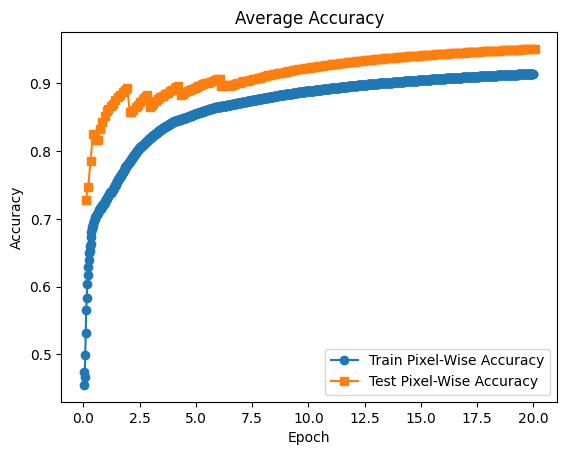

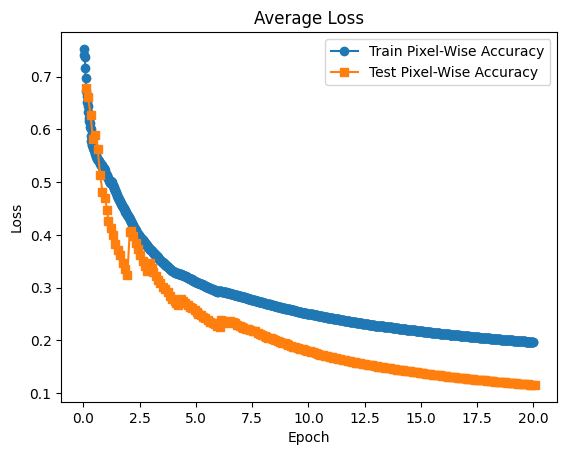

In [ ]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

satellite image (3 bands only)


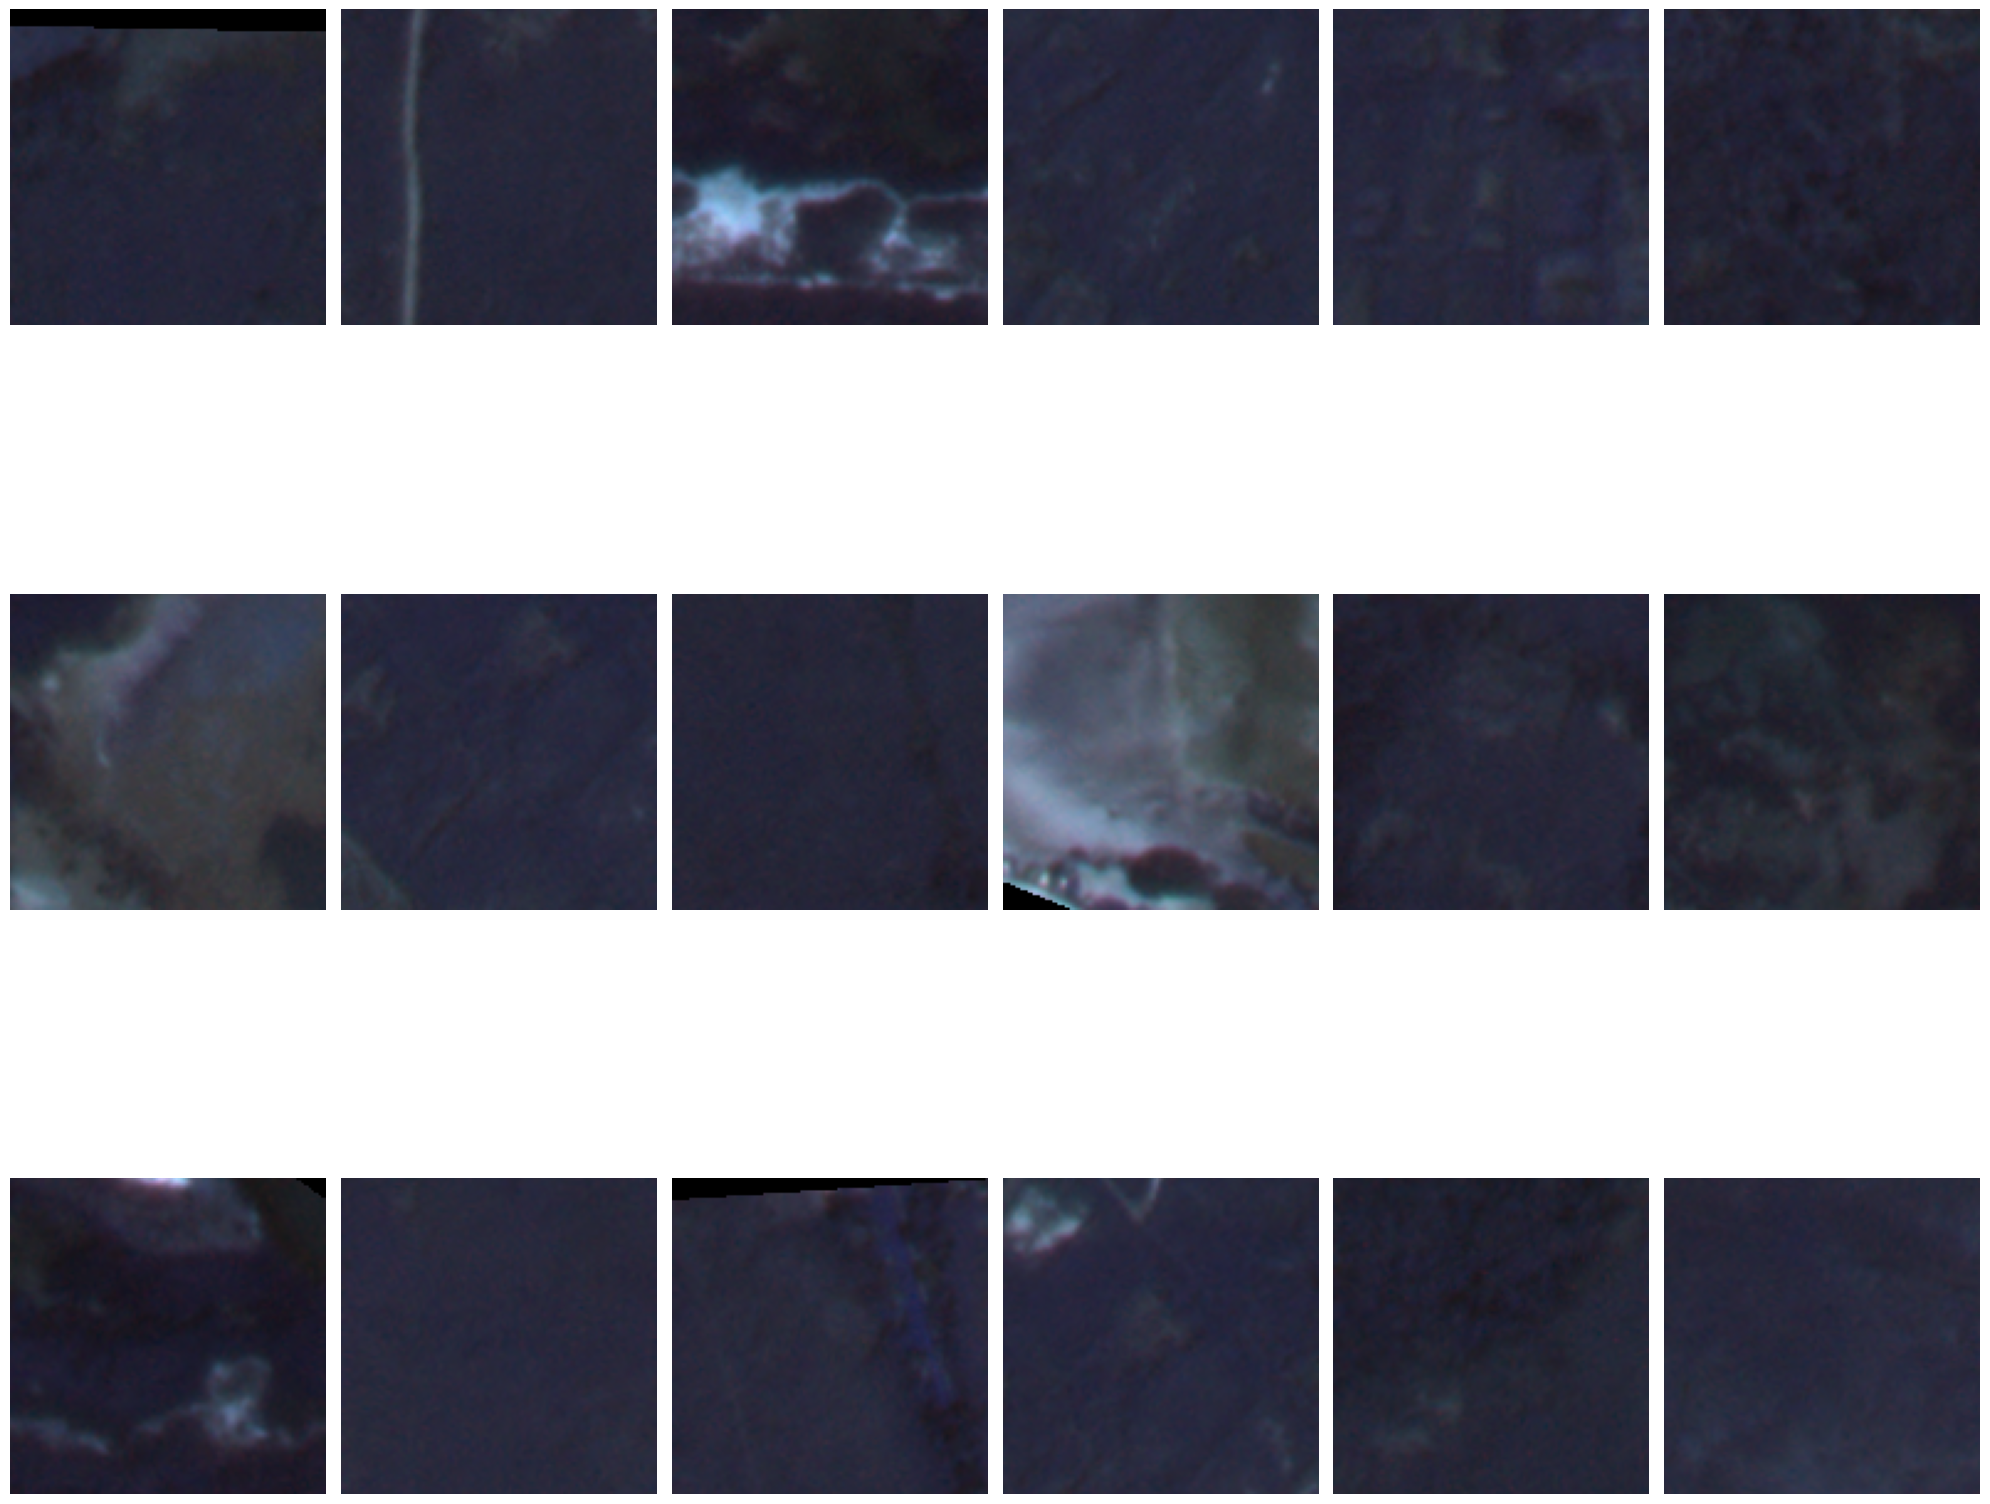

satellite image with predicted mask


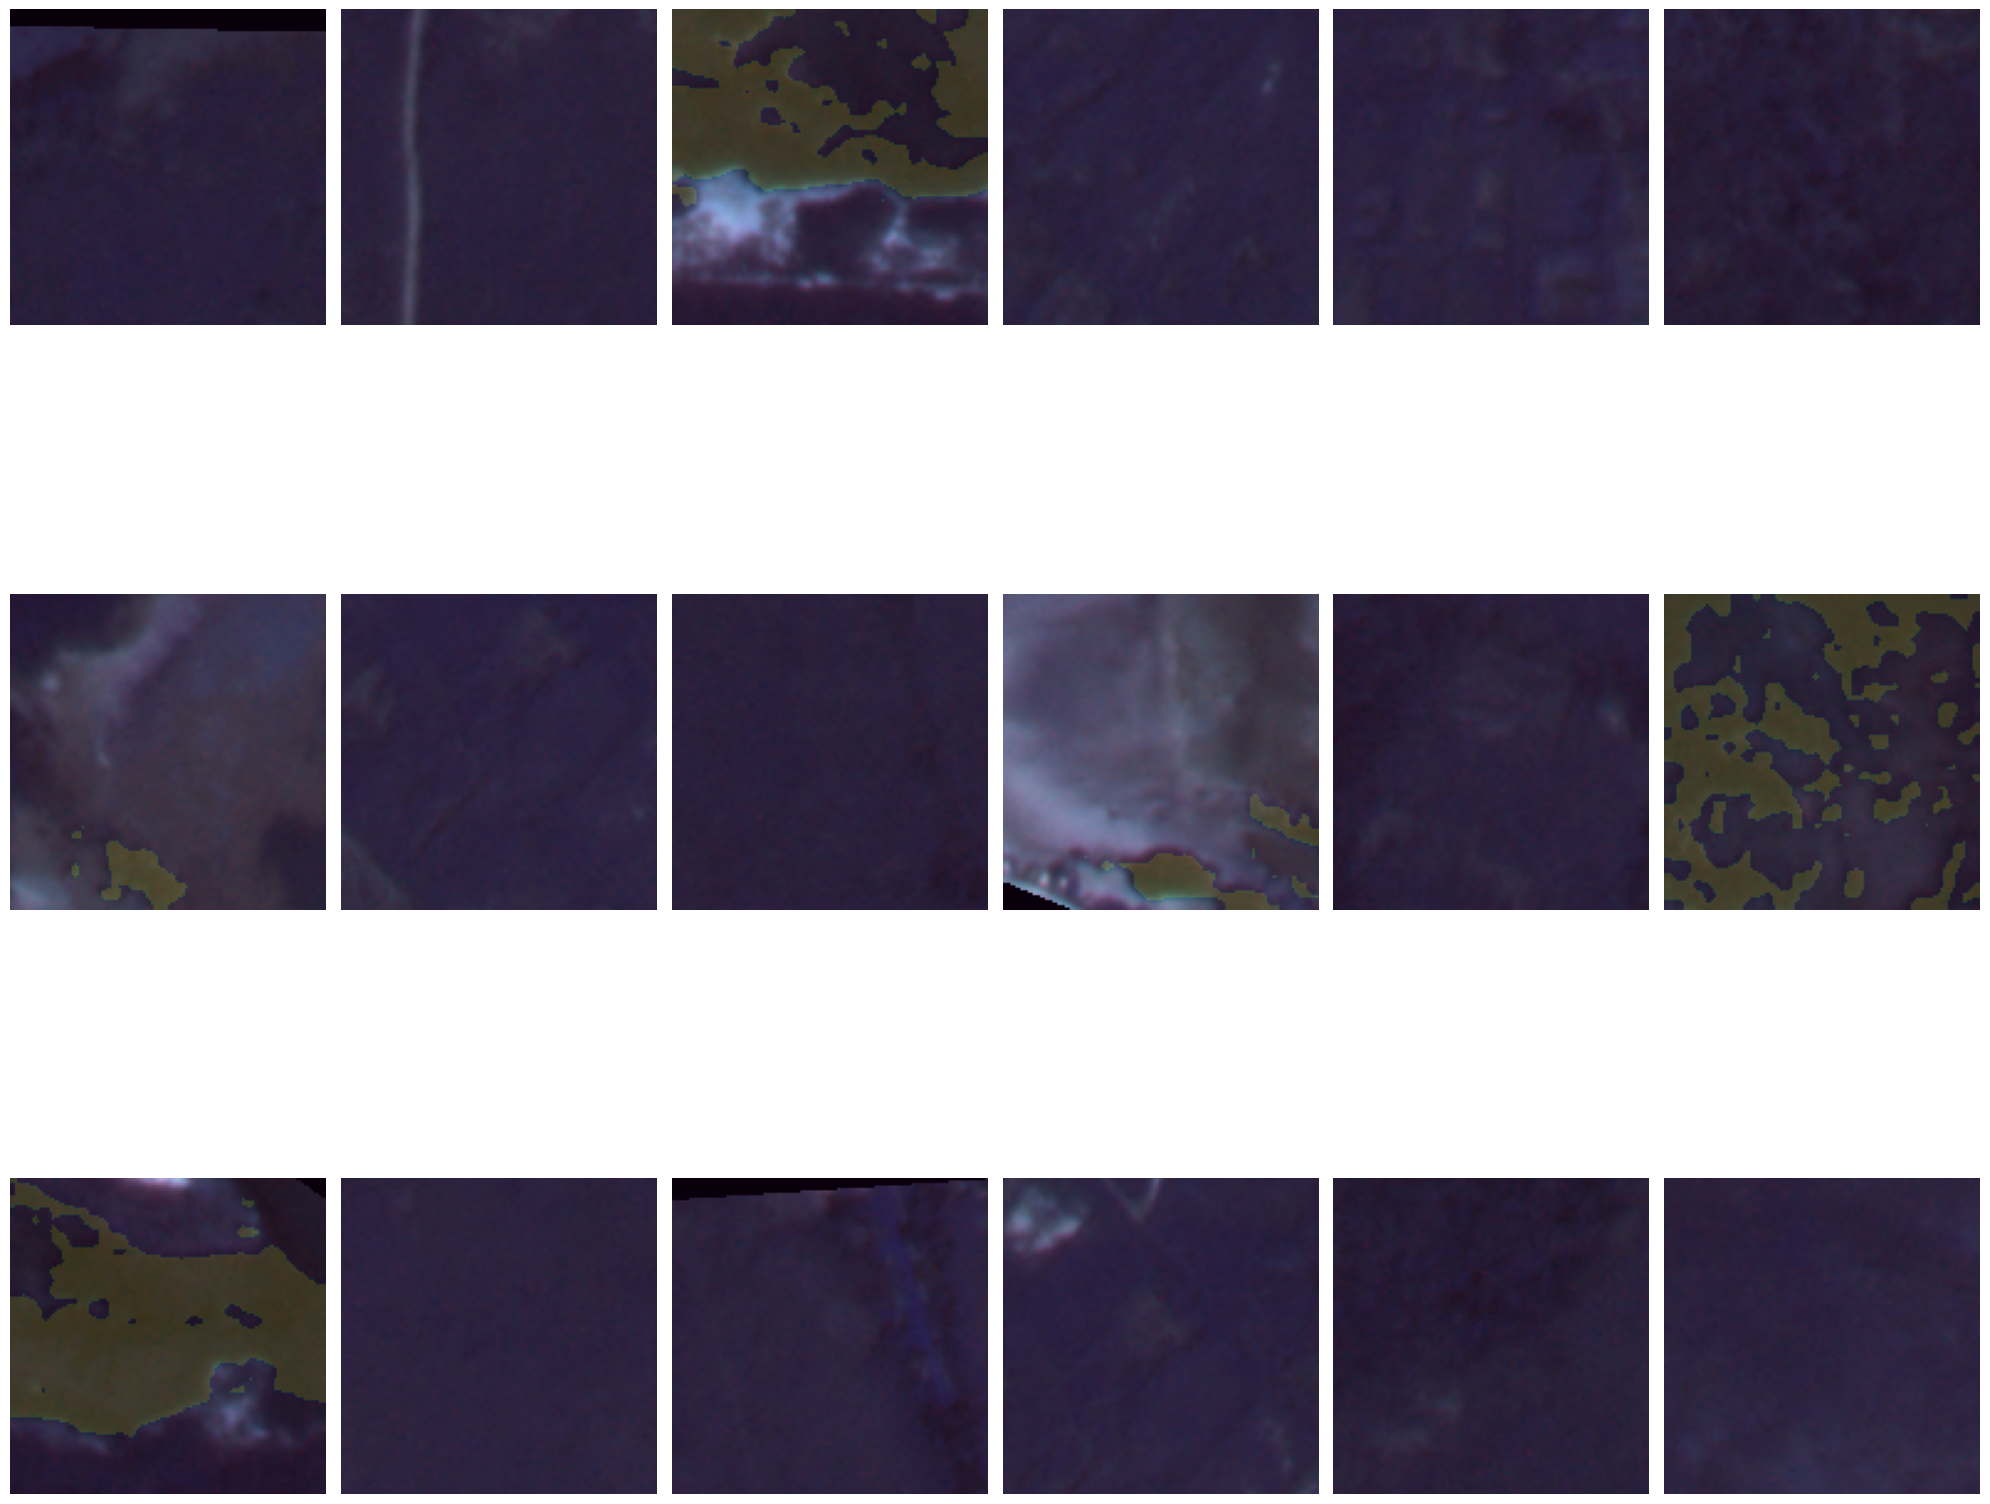

satellite image with true mask


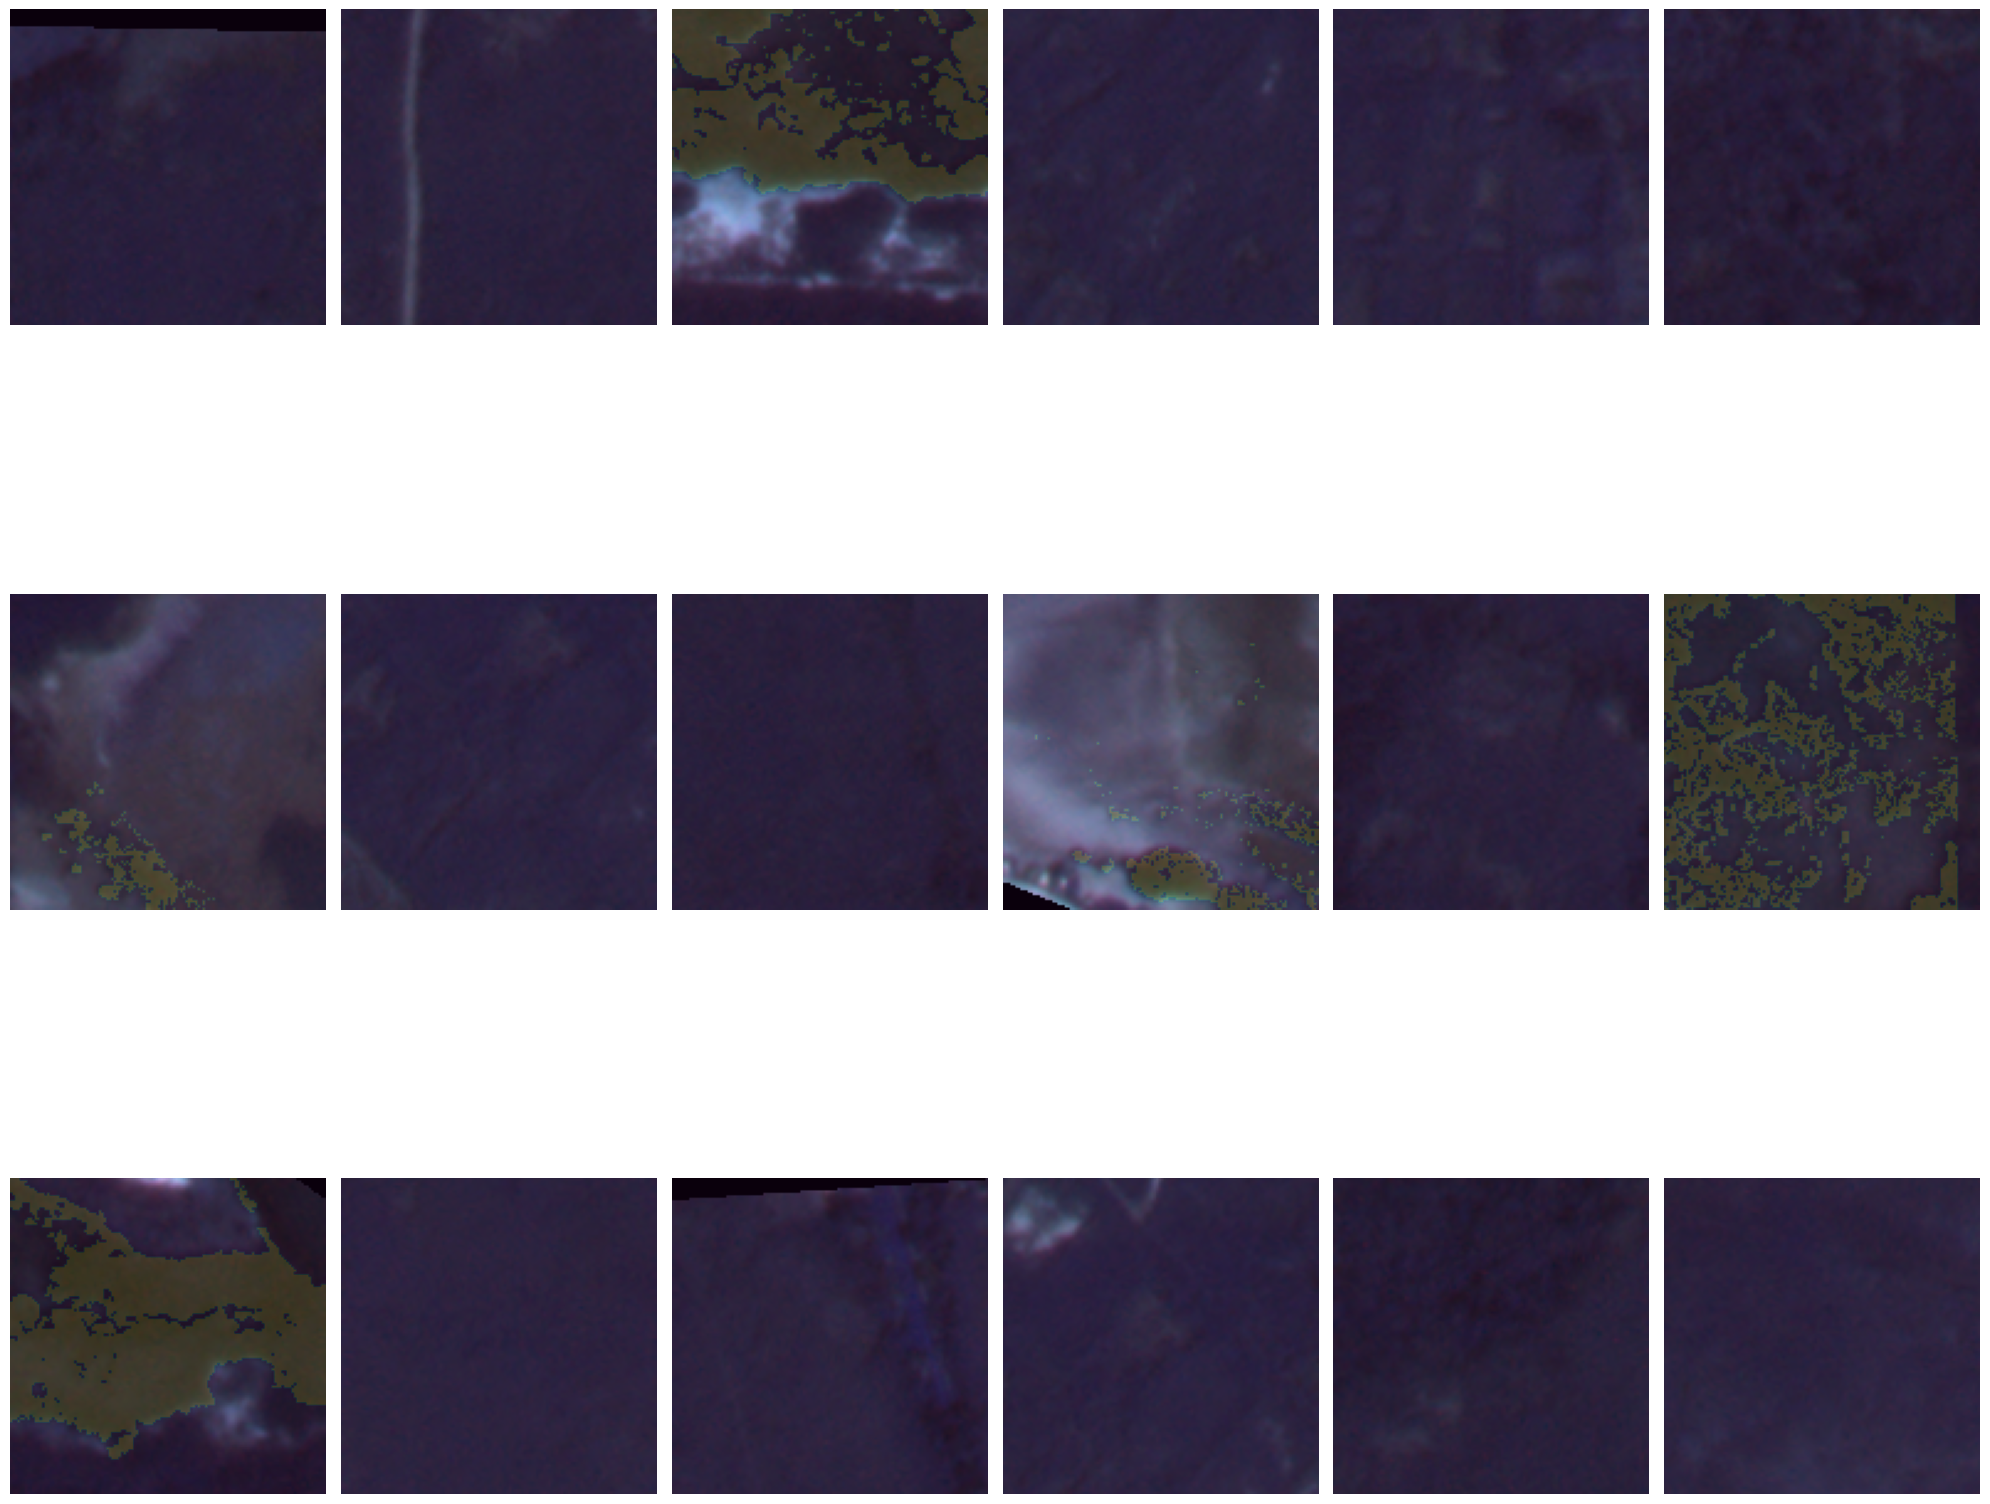

In [ ]:
model.eval()
next_test_batch = next(test_batch)
test_pixel_values = next_test_batch[0].to(device)
test_labels = next_test_batch[1].to(device)
test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
test_predicted = test_upsampled_logits.argmax(dim=1)
test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
test_true_labels = test_labels[test_mask].detach().cpu().numpy()
test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
reshaped_true = test_true_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
reshaped_pred = test_pred_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
rgb_pixels = test_pixel_values.detach().cpu().numpy()[:, 0:3,:,:]
rgb_pixels = rearrange(rgb_pixels, "b c w h -> b w h c")/np.max(rgb_pixels)
num_rows = 3
num_cols = 6

print('satellite image (3 bands only)')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()



print('satellite image with predicted mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_pred[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()


print('satellite image with true mask')
# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(num_rows*num_cols):
    img = rgb_pixels[i]
    mask = reshaped_true[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.15, cmap='viridis')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()